Epoch     0 | PDE loss: 1.5806e+01 | BC loss: 1.5723e+00 | Total: 1.7378e+01
Epoch  1000 | PDE loss: 7.1226e-04 | BC loss: 1.0822e-03 | Total: 1.7945e-03
Epoch  2000 | PDE loss: 3.2095e-04 | BC loss: 3.5377e-05 | Total: 3.5633e-04
Epoch  3000 | PDE loss: 1.6686e-04 | BC loss: 2.8766e-05 | Total: 1.9563e-04
Epoch  4000 | PDE loss: 7.7728e-05 | BC loss: 2.1785e-05 | Total: 9.9513e-05


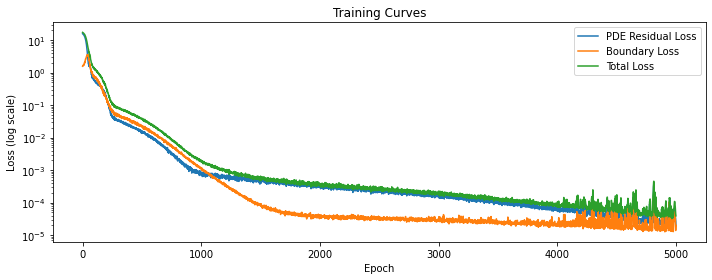

Interior MSE: 1.8035e-05


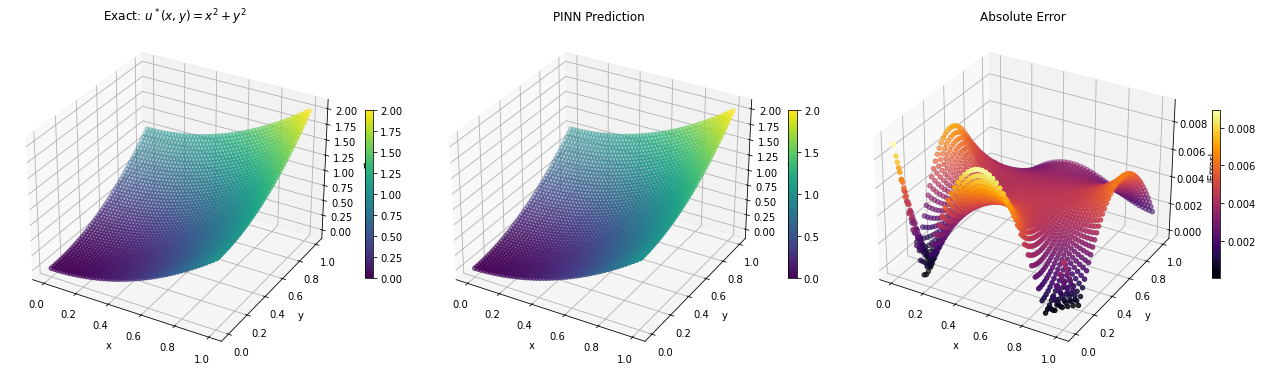

Boundary MSE: 2.1405e-05


In [5]:
"""
=====================================================================
                    2D Poisson PDE PINN Solver Example
=====================================================================

Description:
------------
This script demonstrates how to solve a 2D Poisson PDE using a 
Physics-Informed Neural Network (PINN) with PyTorch. The PDE and its 
boundary conditions are chosen such that an analytical solution exists.
Specifically, we solve the following problem on the domain Ω = [0,1] × [0,1]:

   PDE:    Δu(x,y) = 4,      for (x,y) ∈ Ω,
   BC:     u(x,y) = x² + y², for (x,y) ∈ ∂Ω.

The analytical (exact) solution is:
   u*(x,y) = x² + y²,
since Δ(x² + y²) = 2 + 2 = 4 and the boundary condition is satisfied.

PINN Approach:
--------------
1. A feed-forward neural network is defined to approximate the solution u(x,y).
2. The PDE residual is computed using automatic differentiation (autograd):
      r(x,y) = Δu(x,y) - 4.
3. Dirichlet boundary conditions are imposed by sampling boundary points and 
   computing the Mean Squared Error (MSE) between the network output and the 
   target u(x,y) = x² + y².
4. The total loss is a combination of the interior (PDE) loss and the boundary loss.
5. The network is trained using the Adam optimizer.
6. After training, the learned solution is evaluated on a grid, and 3D scatter 
   plots are used to visualize the exact solution, the PINN prediction, and 
   the absolute error.
7. Finally, the interior and boundary MSEs are printed.

=====================================================================
Dependencies:
--------------
- torch (PyTorch)
- numpy
- matplotlib

=====================================================================
Usage:
------
Simply run this script. It will train the PINN, plot the training curves, 
and display 3D scatter plots for the exact solution, the PINN prediction, 
and the error. The printed metrics show the accuracy in the domain interior 
and on the boundaries.

=====================================================================
"""

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1) Domain Setup
# --------------------------------------------------------
# We solve on the domain [0,1] x [0,1].
# PDE: Δu(x,y) = 4, Boundary: u(x,y) = x^2 + y^2.
# Exact solution: u*(x,y) = x^2 + y^2.
def exact_solution(x, y):
    return x**2 + y**2

# 2) Neural Network Model (Simple FeedForward)
class PINN2D(nn.Module):
    def __init__(self, layers=[2, 32, 32, 32, 1]):
        """
        layers: e.g. [2, 32, 32, 32, 1] means input_dim=2, three hidden layers
                with 32 neurons each, and output_dim=1.
        """
        super().__init__()
        self.activation = nn.Tanh()
        net = []
        for i in range(len(layers)-2):
            net.append(nn.Linear(layers[i], layers[i+1]))
            net.append(nn.Tanh())
        net.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*net)
    
    def forward(self, x):
        # x shape: (N,2)
        return self.model(x)

# 3) PDE Residual: Laplacian(u) = 4
def pde_residual(model, x, y):
    """
    Computes the PDE residual:
         r(x,y) = u_xx + u_yy - 4,
    using autograd for derivatives.
    """
    inp = torch.cat([x, y], dim=1)  # shape (N,2)
    u = model(inp)
    
    # First derivatives
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                              create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u),
                              create_graph=True)[0]
    
    # Second derivatives
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                               create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y),
                               create_graph=True)[0]
    
    # PDE residual: (u_xx + u_yy) - 4
    residual = (u_xx + u_yy) - 4.0
    return residual

# 4) Training Loop for the PINN
def train_pinn(num_epochs=5000, lr=1e-3, print_every=1000, n_int=2000, n_bc=400):
    """
    num_epochs: Total training iterations.
    lr: Learning rate.
    print_every: Frequency of printing loss.
    n_int: Number of interior points.
    n_bc: Total number of boundary points (divided among 4 edges).
    """
    model = PINN2D(layers=[2, 32, 32, 32, 1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Tracking losses
    losses_pde = []
    losses_bc  = []
    losses_all = []
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Sample interior points (domain: [0,1]x[0,1])
        x_int = torch.rand(n_int, 1)
        y_int = torch.rand(n_int, 1)
        x_int.requires_grad_(True)
        y_int.requires_grad_(True)
        
        # Compute PDE residual loss
        res = pde_residual(model, x_int, y_int)
        loss_pde = torch.mean(res**2)
        
        # Sample boundary points for Dirichlet BC (4 edges)
        n_each = n_bc // 4
        
        # Edge 1: x = 0
        y_bc1 = torch.rand(n_each, 1)
        x_bc1 = torch.zeros_like(y_bc1)
        # Edge 2: x = 1
        y_bc2 = torch.rand(n_each, 1)
        x_bc2 = torch.ones_like(y_bc2)
        # Edge 3: y = 0
        x_bc3 = torch.rand(n_each, 1)
        y_bc3 = torch.zeros_like(x_bc3)
        # Edge 4: y = 1
        x_bc4 = torch.rand(n_each, 1)
        y_bc4 = torch.ones_like(x_bc4)
        
        # Stack boundary points together
        x_bc = torch.cat([x_bc1, x_bc2, x_bc3, x_bc4], dim=0)
        y_bc = torch.cat([y_bc1, y_bc2, y_bc3, y_bc4], dim=0)
        
        # Evaluate model on boundary
        u_bc_pred = model(torch.cat([x_bc, y_bc], dim=1))
        # Compute exact boundary values
        u_bc_true = x_bc**2 + y_bc**2
        
        loss_bc = torch.mean((u_bc_pred - u_bc_true)**2)
        
        # Total loss
        loss = loss_pde + loss_bc
        loss.backward()
        optimizer.step()
        
        losses_pde.append(loss_pde.item())
        losses_bc.append(loss_bc.item())
        losses_all.append(loss.item())
        
        if epoch % print_every == 0:
            print(f"Epoch {epoch:5d} | PDE loss: {loss_pde.item():.4e} | BC loss: {loss_bc.item():.4e} | Total: {loss.item():.4e}")
    
    return model, losses_pde, losses_bc, losses_all

# 5) Train the model
model, losses_pde, losses_bc, losses_all = train_pinn(num_epochs=5000, lr=1e-3)

# 6) Plot the training curves
plt.figure(figsize=(10,4))
plt.plot(losses_pde, label='PDE Residual Loss')
plt.plot(losses_bc,  label='Boundary Loss')
plt.plot(losses_all, label='Total Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training Curves')
plt.legend()
plt.tight_layout()
plt.show()

# 7) Evaluate the learned solution on a grid
N_test = 50
x_vals = np.linspace(0,1,N_test)
y_vals = np.linspace(0,1,N_test)
X, Y = np.meshgrid(x_vals, y_vals, indexing='ij')
xy_pairs = np.stack([X.ravel(), Y.ravel()], axis=1)
xy_torch = torch.tensor(xy_pairs, dtype=torch.float)

with torch.no_grad():
    u_pred = model(xy_torch).numpy().reshape(N_test, N_test)
u_exact = X**2 + Y**2

# Compute interior MSE
mse_interior = np.mean((u_pred - u_exact)**2)
print(f"Interior MSE: {mse_interior:.4e}")

# 8) 3D Scatter Plots for Visualization: Exact, Prediction, and Absolute Error
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18,5))

# Scatter plot of the exact solution
ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(X, Y, u_exact, c=u_exact, cmap='viridis')
ax1.set_title("Exact: $u^*(x,y)=x^2+y^2$")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("u")
plt.colorbar(sc1, ax=ax1, shrink=0.5)

# Scatter plot of the PINN prediction
ax2 = fig.add_subplot(132, projection='3d')
sc2 = ax2.scatter(X, Y, u_pred, c=u_pred, cmap='viridis')
ax2.set_title("PINN Prediction")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("u")
plt.colorbar(sc2, ax=ax2, shrink=0.5)

# Scatter plot of the absolute error
error = np.abs(u_pred - u_exact)
ax3 = fig.add_subplot(133, projection='3d')
sc3 = ax3.scatter(X, Y, error, c=error, cmap='inferno')
ax3.set_title("Absolute Error")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("|Error|")
plt.colorbar(sc3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.show()

# 9) Evaluate Boundary Error
def boundary_mse(model, n_points=100):
    # Bottom boundary: y=0
    x_ = np.linspace(0,1,n_points)
    y_ = np.zeros_like(x_)
    xy_t = torch.tensor(np.vstack([x_, y_]).T, dtype=torch.float)
    with torch.no_grad():
        u_ = model(xy_t).numpy().ravel()
    u_gt = x_**2 + y_**2
    err_bottom = np.mean((u_ - u_gt)**2)
    
    # Top boundary: y=1
    y_ = np.ones_like(x_)
    xy_t = torch.tensor(np.vstack([x_, y_]).T, dtype=torch.float)
    with torch.no_grad():
        u_ = model(xy_t).numpy().ravel()
    u_gt = x_**2 + y_**2
    err_top = np.mean((u_ - u_gt)**2)
    
    # Left boundary: x=0
    y_ = np.linspace(0,1,n_points)
    x_ = np.zeros_like(y_)
    xy_t = torch.tensor(np.vstack([x_, y_]).T, dtype=torch.float)
    with torch.no_grad():
        u_ = model(xy_t).numpy().ravel()
    u_gt = x_**2 + y_**2
    err_left = np.mean((u_ - u_gt)**2)
    
    # Right boundary: x=1
    x_ = np.ones_like(y_)
    xy_t = torch.tensor(np.vstack([x_, y_]).T, dtype=torch.float)
    with torch.no_grad():
        u_ = model(xy_t).numpy().ravel()
    u_gt = x_**2 + y_**2
    err_right = np.mean((u_ - u_gt)**2)
    
    return (err_bottom + err_top + err_left + err_right)/4.0

mse_bc = boundary_mse(model)
print(f"Boundary MSE: {mse_bc:.4e}")
